In [60]:
import numpy as np
import pandas as pd
from pydub import AudioSegment
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [ ]:
audio = pd.read_csv('./data/converted_data/16000Hz_2s_each_10s-2025-04-22_16-43-38_silence.csv')

In [ ]:
audio.shape

(32000, 4)

In [ ]:
audio.head()

,sample_num,time_sec,adc_value,voltage
0,0,0.000000,33320,1.677821
1,1,0.000063,33304,1.677015
2,2,0.000125,33304,1.677015
3,3,0.000188,33320,1.677821
4,4,0.000250,33320,1.677821


<Axes: xlabel='time_sec'>

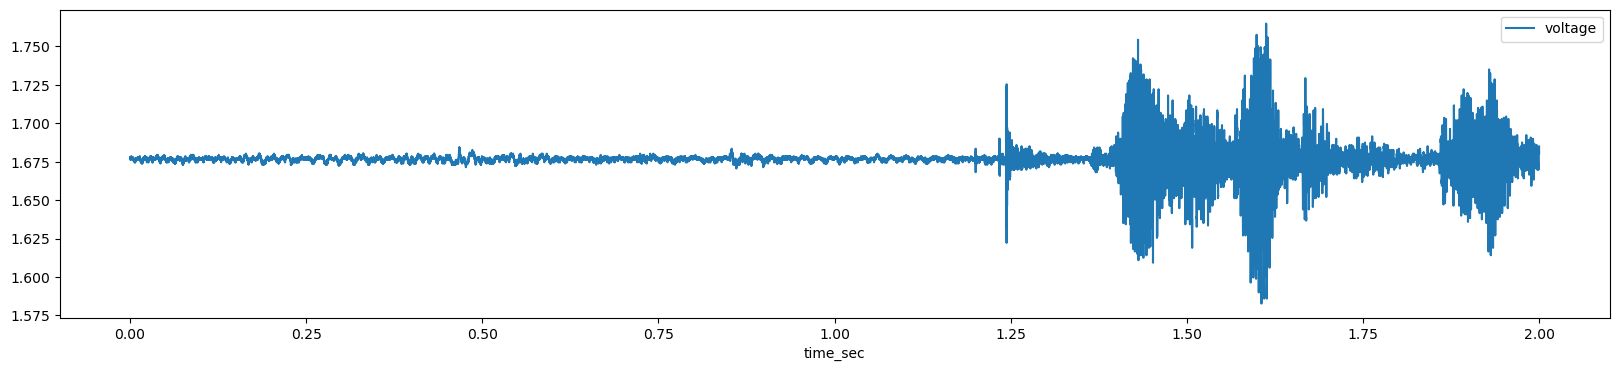

In [ ]:
audio.plot(x='time_sec', y='voltage', figsize=(20, 4))

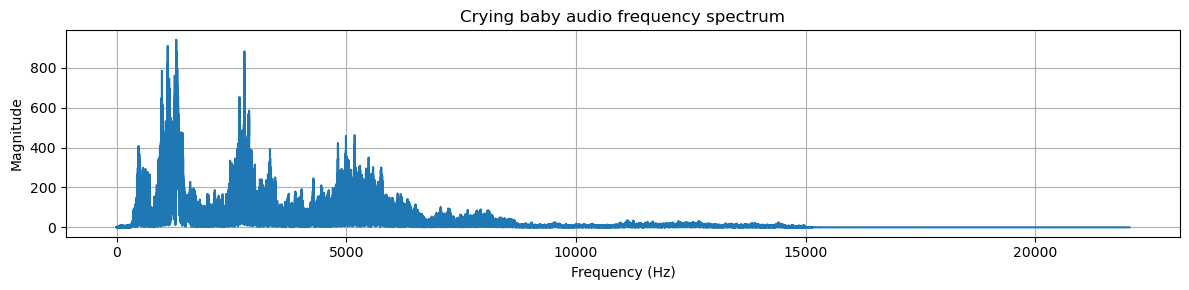

In [ ]:
# Load mp3 file
audio = AudioSegment.from_mp3("data/reference_baby_audio.mp3")
samples = np.array(audio.get_array_of_samples())

# Handle stereo by converting to mono
if audio.channels == 2:
    samples = samples.reshape((-1, 2))
    samples = samples.mean(axis=1)

# Normalize to float32 [-1, 1]
samples = samples.astype(np.float32) / (2**15)

# Sampling rate
sr = audio.frame_rate
n = len(samples)

# Compute FFT
yf = fft(samples)
xf = fftfreq(n, 1 / sr)

# Only take the positive frequencies
baby_xf = xf[:n // 2]
baby_yf = np.abs(yf[:n // 2])

# Plot
plt.figure(figsize=(12, 3))
plt.plot(baby_xf, baby_yf)
plt.title('Crying baby audio frequency spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.show()

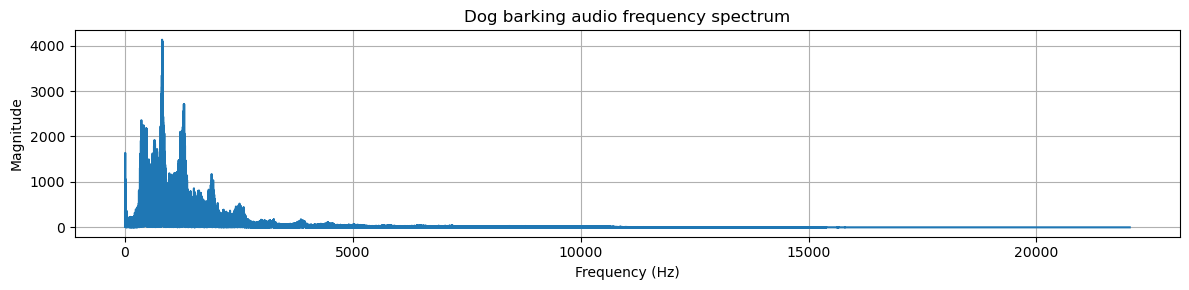

In [ ]:
# Load mp3 file
audio = AudioSegment.from_mp3("data/reference_dog_audio.mp3")
samples = np.array(audio.get_array_of_samples())

# Handle stereo by converting to mono
if audio.channels == 2:
    samples = samples.reshape((-1, 2))
    samples = samples.mean(axis=1)

# Normalize to float32 [-1, 1]
samples = samples.astype(np.float32) / (2**15)

# Sampling rate
sr = audio.frame_rate
n = len(samples)

# Compute FFT
yf = fft(samples)
xf = fftfreq(n, 1 / sr)

# Only take the positive frequencies
dog_xf = xf[:n // 2]
dog_yf = np.abs(yf[:n // 2])

# Plot
plt.figure(figsize=(12, 3))
plt.plot(dog_xf, dog_yf)
plt.title('Dog barking audio frequency spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.show()

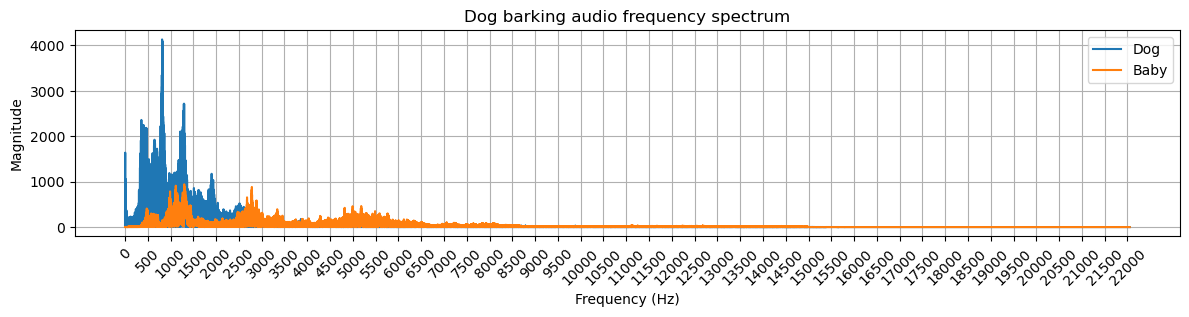

In [28]:
plt.figure(figsize=(12, 3))
plt.plot(dog_xf, dog_yf, label='Dog')
plt.plot(baby_xf, baby_yf, label='Baby')
plt.title('Dog barking audio frequency spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.xticks(np.arange(0, max(baby_xf), 500))
plt.tick_params('x', rotation=45)
plt.show()

In [36]:
results = pd.read_csv('evaluation_results.csv').iloc[:54]
results.head(3)

,filename,ground_truth,prediction,energy,result
0,16000Hz_2s_each_1s-2025-05-12_20-20-02_silence...,False,True,0.000725,Incorrect
1,16000Hz_2s_each_1s-2025-05-12_20-23-19_baby.csv,True,True,0.001216,Correct
2,16000Hz_2s_each_1s-2025-05-12_20-19-40_silence...,False,True,0.000753,Incorrect


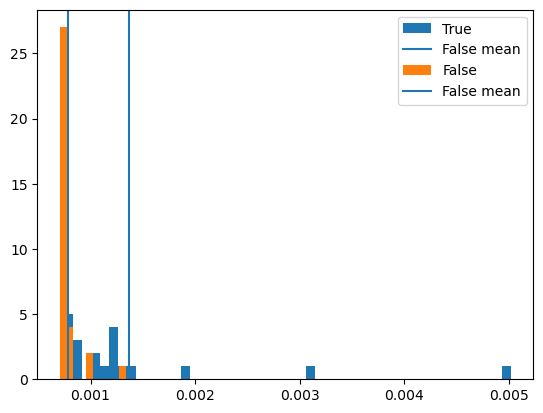

In [58]:
plt.hist(
    results[results['ground_truth']=='True']['energy'],
    label='True',
    bins=50
    )
plt.axvline(
    results[results['ground_truth']=='True']['energy'].mean(),
    label='False mean'
    )
plt.hist(
    results[results['ground_truth']=='False']['energy'],
    label='False',
    bins=10
    )
plt.axvline(
    results[results['ground_truth']=='False']['energy'].mean(),
    label='False mean'
    )
plt.legend()

In [66]:
# Sort by predictor
results_sorted = results.sort_values('energy')

# Try all unique thresholds
thresholds = results_sorted['energy'].unique()
best_thresh = None
best_score = 0

for thresh in thresholds:
    preds = (results['energy'] >= thresh).astype(int)
    score = accuracy_score(
        results['ground_truth'].map({'False': 0, 'True': 1}), 
        preds
        )
    if score > best_score:
        best_score = score
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.5f}, Accuracy: {best_score:.3f}")

Best threshold: 0.00079, Accuracy: 0.926
